## Background

In this notebook, I'll walk through a modified algorithm (suggested by Claude) to calculate the percentage of positive space in the letters of an image. I'll define this percentage as:

<br>

$$\frac{\text{Area of Letter}}{\text{Area of Bounding Box Around Letter}}$$

<br>

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I'll train a neural network for this task. This is one of many notebooks in my [**TypefaceClassifier**](https://vishalbakshi.github.io/blog/index.html#category=TypefaceClassifier) project series.

In [91]:
#| code-fold: true
#| code-summary: "Show imports"
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Find the Contours of a Binarized Image

As we do with all of these algorithms (thus far), we start by loading the image of text and binarizing it.

In [125]:
image_path = 'serif-76px.png'

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
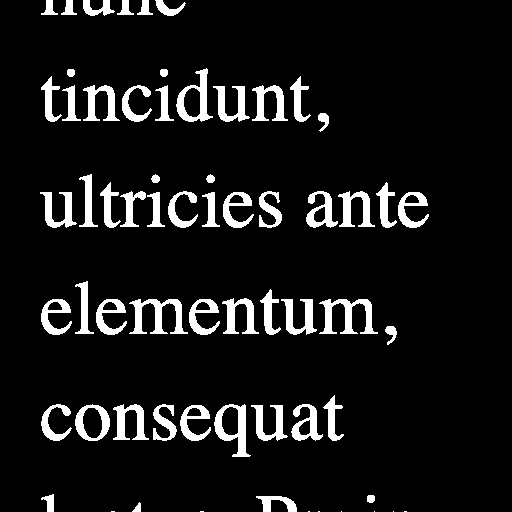

In [126]:
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

Then we `findContours` in the image. In order to find both the inner and outer contours (for letters with "holes" in them like `o`, `d`, `e` `p` `q` and so on) we use the `cv2.RETR_TREE` parameter.

This returns a `hierarchy` which has the shape `1, N, 4` where `N` is the number of contours. The `4` elements per contour are `[Next, Previous, First_Child, Parent]`. If a contour doesn't have one of those, the value of `hierarchy` is `-1`.

In [127]:
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [128]:
hierarchy.shape

(1, 75, 4)

Visualizing the contours---note how the inside shapes (holes) of letters like `d` are also identified as contours.

In [129]:
#| code-fold: true
#| code-summary: "Show `plot_contour` definition"
def plot_contour(img, contour):
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.drawContours(img_rgb, contour, -1, (250, 0, 92), 2)
  fig, ax = plt.subplots(1, 1 , figsize=(5,5))
  fig.suptitle(f'Binarized Contours', fontsize=16)
  ax.imshow(img_rgb);

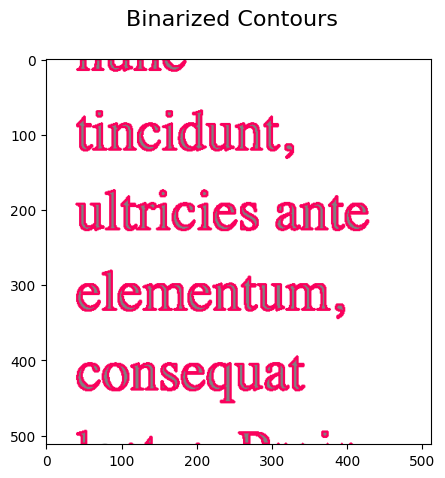

In [130]:
plot_contour(img, contours)

## Calculating Bounding Box and Contour Areas

As an example, I'll calculate the area inside the contours of the letter `d` (it has an outer contour, `67` and an inner contour `68`):

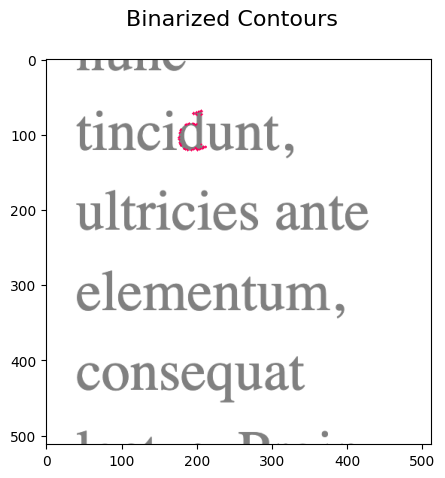

In [131]:
plot_contour(img, contours[67]) # outside contour

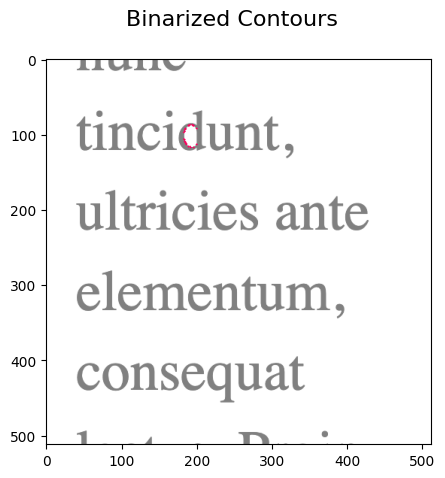

In [132]:
plot_contour(img, contours[68]) # inside contour

The bounding box (rectangle) around the contour is calculated with `boundingRect`:

In [133]:
x, y, w, h = cv2.boundingRect(contours[67]) # outer contour bounding box

The rectangle's area is:

In [134]:
rect_area = w*h
rect_area

1998

The area of the `contour` is a bit more involved as it's the difference between the outer area of the `d` and the inner (hole) area of the `d`:

In [135]:
outer_area = cv2.contourArea(contours[67])
outer_area

1049.5

The `hierarchy` of this `d`'s outer contour tells us that is has no parent (`-1`) and it has a child `68`.

In [136]:
hierarchy[0][67]

array([69, 66, 68, -1], dtype=int32)

Iterating through the children (it has 1 child) we calculate the inner contour's area:

In [157]:
child = hierarchy[0][67][2]  # First child
inner_area = 0

while child != -1 and child < len(contours):
  inner_area += cv2.contourArea(contours[child])
  child = hierarchy[0][child][2]

In [158]:
inner_area

425.5

In this case, since there is only one child, we could calculate the contour directly:

In [139]:
cv2.contourArea(contours[68])

425.5

The area of the letter is the difference between inner and outer areas:

In [140]:
d_area = outer_area - inner_area
d_area

624.0

The percentage of positive space of the letter `d`, in pixels, is the area of the letter divided by the area of the bounding box:

In [141]:
d_area / rect_area

0.3123123123123123

If we had ignored the inner area of the `d` and used the outer contour area, this percentage would be significantly larger:

In [142]:
outer_area / rect_area

0.5252752752752753

## Calculating Average Letter Area Ratio of Different Images of Text

I'll wrap all of this functionality into a set of functions (well, Claude did that for me to begin with) and then test it out on different images of text. I'm also calculating the outer contour area so I can illustrate the difference of areas for an image.

In [186]:
#| code-fold: true
#| code-summary: "Show `pct_positive_space` definition"
def get_letter_area(contour, hierarchy, contours, idx):
    outer_area = cv2.contourArea(contour)
    inner_area = 0

    # Check if hierarchy is valid
    if hierarchy is None or len(hierarchy) < 3:
        return outer_area  # Return outer area if hierarchy is invalid

    child = hierarchy[idx][2]  # First child

    while child != -1 and child < len(contours):
        inner_area += cv2.contourArea(contours[child])
        # Safely get next child
        #if child < len(hierarchy) and len(hierarchy[child]) > 0:
        child = hierarchy[child][2]
        # else:
        #     break  # Exit loop if we can't get next child safely

    return outer_area - inner_area

def letter_area_ratio(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    area_ratios = []
    total_outer_area = 0
    total_box_area = 0
    total_letter_area = 0

    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] == -1:  # This is an outer contour
            x, y, w, h = cv2.boundingRect(contour)
            rect_area = w * h
            outer_area = cv2.contourArea(contour)
            letter_area = get_letter_area(contour, hierarchy[0], contours, i)

            total_box_area += rect_area
            total_outer_area += outer_area
            total_letter_area += letter_area

            if rect_area > 0:
                ratio = letter_area / rect_area
                area_ratios.append(ratio)

    avg_ratio = np.median(area_ratios) if area_ratios else 0
    return avg_ratio, total_box_area, total_outer_area, total_letter_area

I also asked Claude for a function to visualize the original image, the bounding boxes, the outer contours, and the refined (outer - inner) contours.

In [187]:
#| code-fold: true
#| code-summary: "Show `visualize_analysis` definition"
def visualize_analysis(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours with hierarchy
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    avg_ratio, total_box_area, total_outer_area, total_letter_area = letter_area_ratio(image_path)

    img_boxes = img_rgb.copy()
    img_contours = img_rgb.copy()
    img_refined = img_rgb.copy()

    # Draw bounding boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_boxes, (x, y), (x+w, y+h), (250, 0, 92), 2)

    # Draw all contours, including inner ones
    cv2.drawContours(img_refined, contours, -1, (250, 0, 92), 2)

    # Draw only outer contours
    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] == -1:  # This is an outer contour
            cv2.drawContours(img_contours, [contour], 0, (250, 0, 92), 2)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'Letter Analysis (Avg Area Ratio: {avg_ratio:.2f})', fontsize=16)

    axs[0, 0].imshow(img_rgb)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(img_boxes)
    axs[0, 1].set_title(f'Bounding Boxes\nTotal Area: {total_box_area:.0f} pixels')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(img_contours)
    axs[1, 0].set_title(f'Outer Contours\nTotal Area: {total_outer_area:.0f} pixels')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(img_refined)
    axs[1, 1].set_title(f'Outer - Inner Contours\nTotal Area: {total_letter_area:.0f} pixels')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

Across the entire image, the refined (outer - inner) contour area is about 10% less than the outer area.

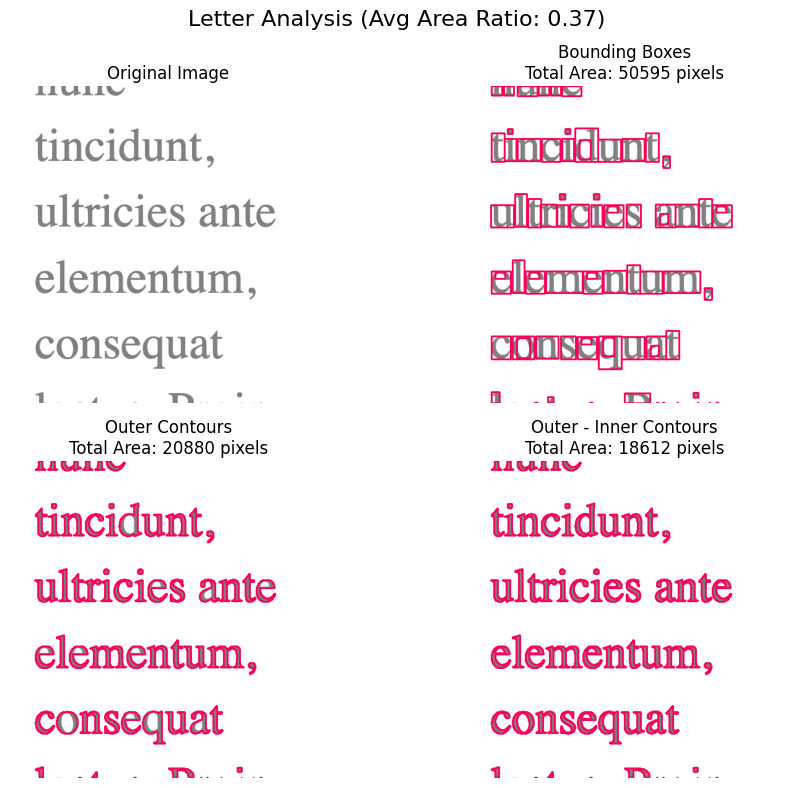

In [188]:
visualize_analysis('serif-76px.png')

For the same typeface (`serif`) the average percentage of positive space is (kind of?) consistent.

In [190]:
for sz in [18, 24, 36, 76, 330]:
  avg_ratio, _, _, _ = letter_area_ratio(f'serif-{sz}px.png')
  print('serif', sz, avg_ratio)

serif 18 0.25
serif 24 0.30213903743315507
serif 36 0.32516339869281047
serif 76 0.37477598566308246
serif 330 0.425178283873936


For a different typeface (`display`), the average ratio (of letter area to bounding box area) is considerably larger:

In [191]:
for sz in [18, 24, 36, 76, 330]:
  avg_ratio, _, _, _ = letter_area_ratio(f'display-{sz}px.png')
  print('display', sz, avg_ratio)

display 18 0.4
display 24 0.4444444444444444
display 36 0.5015625
display 76 0.5613636363636364
display 330 0.579352195423624


## Final Thoughts

Given that the median letter area ratio for `display` is larger than `serif` texts, I think this algorithm is a good candidate for distinguishing between different typefaces.

I'm continually impressed by the functionality offered in the OpenCV library. I'm also impressed by Claude's ability to provide me simple, usable and understandable code for OpenCV.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).